Notes from [Introduction to Synthetic Aperture Radar Using Python and MATLAB](https://ieeexplore.ieee.org/document/9893146).

# BackProjection

Compared to the range-Doppler and polar format alogirthms, backprojection does not need to make as many assumptions, such as about cell migration or platform motion. Its implementation is basically the same regardless of the imaging method. Backprojection also forms images in the ground plane, which makes orthorectification and registration easier and more efficient.

### The Fourier Slice Theorem and Radon Transforms

<img src="imgs/fourier_slice_theorem.png" width="700" height="700" style='margin-left: auto; margin-right: auto;' />

In the above image, showing the geometry of X-ray tomography, the X-ray paths form parallel projections of the density function $f(x, y)P_{\theta}(t)$. According to the Fourier Slice Theorem, the 1-D Fourier Transform of of a parallel projection of a density function is a slice of the 2-D Fourier Transform of the density function. Therefore, if one gets these projections from multiple angles, they get get back to the original image.
<br>
<br>
The time domain signal generated by the X-rays is the 1-D projection of the density function, and is defined by the Radon Transform. The Radon Transfrom is given by
$$ P_{\theta}(t) = \int_{l} f(x, y)ds = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}f(x, y)\delta(x\cos(\theta)+y\sin(\theta)-t)dxdy) $$
The 1-D Fourier Transform of this gives us
$$ S_{\theta}(\omega) = \int_{-\infty}^{\infty}P_{\theta}e^{-i2\pi \omega t}dt $$
and the 2-D Fourier Transform of the orginal density function is
$$ F(u, v) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}f(x, y)e^{-i2\pi (ux + vy)}dxdy $$
Since no assumptions about the orientation are needed, $ \theta $ and $ v $ can be 0. This gives us
$$ F(u, 0) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}f(x, y)e^{-i2\pi ux}dxdy $$
Since the phase term is no only a function of x, the integral can now become
$$ F(u, 0) = \int_{-\infty}^{\infty}[\int_{-\infty}^{\infty}f(x, y)]e^{-i2\pi ux}dx $$
The term inside the bracks is then a projection across lines of constant $x$, so
$$ P_{\theta = 0} = \int_{-\infty}^{\infty}f(x, y)dy $$
and
$$ F(u, 0) = \int_{-\infty}^{\infty}P_{\theta = 0}e^{-i2\pi ux}dx $$
This shows that a slice of the 2-Fourier transform at any particular angle is the 1-D Fourier transform of the density function in that direction. Since we made no assumption about the particular angle, we can see that across all angles we end up with
$$ F(u, 0) = S_{\theta = 0}(\omega) $$
$$ F(u, v) = S_{\theta}(\omega) $$

### Filtered Backprojection

Once the 1-D Fourier Transforms of the projections have been collected, we have $F(u, v)$. So we can take the 2-D inverse Fourier transform of this frequency domain representation of the density function to get the density function. This can be written as 
$$ f(x, y) =  \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}F(u, v)e^{i2\pi[ux + vy]}dudv $$
Since the projection functions cover the spatial frequency domain in a polar fashion, the following substatutions can be made
$$ u = \omega \cos(\theta) $$
$$ v = \omega \sin(\theta) $$
$$ dudv = \omega d\omega d\theta $$
which gives us
$$ f(x, y) =  \int_{0}^{2\pi}\int_{0}^{\infty}F(\omega, \theta)e^{i2\pi \omega[x\cos(\theta) + y\sin(\theta)]}\omega d\omega d\theta $$
This can be split into two integrals like
$$ f(x, y) =  \int_{0}^{\pi}\int_{0}^{\infty}F(\omega, \theta)e^{i2\pi \omega[x\cos(\theta) + y\sin(\theta)]}\omega d\omega d\theta + \int_{0}^{\pi}\int_{0}^{\infty}F(\omega, \theta)e^{i2\pi \omega[x\cos(\theta + \pi) + y\sin(\theta + \pi)]}\omega d\omega d\theta $$
Then, using $ F(\omega, \theta + \pi) = F(-\omega, \theta) $ we can get
$$ f(x, y) =  \int_{0}^{\pi}\int_{0}^{\infty}F(\omega, \theta)e^{i2\pi \omega[x\cos(\theta) + y\sin(\theta)]}|\omega| d\omega $$
The inner integral is the convolution of the projection with a filter like
$$ P_{\theta}(t)*h(t) =  \int_{-\infty}^{\infty}F(\omega, \theta)e^{i2\pi[x\cos(\theta) + y\sin(\theta)]}|\omega| d\omega $$
This filtered projection function is the projected back onto the image space along the line the projection was obtained. This can be written as 
$$ f(x, y) = \int_{0}^{\pi}P_{\theta}(t)*h(t)d\theta $$

While all of this math refers to the geometry of X-ray tomography, it works for synthetic aperture radar as well. It works by processing the incoming signal as a projection of the reflectivity function of the target onto the signal. This projection data is the gather across multiple look angles to cover the target's spatial frequency domain. Filtered Backprojection is then used to reconstruct the image from the spatial frequency data.

---
## Examples

In [1]:
from sys import float_info

import numpy as np
import scipy
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.fft import ifft, fft, fftshift, ifftshift, fftfreq
from scipy.fft import ifft2, fft2
from scipy.constants import pi, c

#### Point Target

In [2]:
from point_target import PointTargetKSpace

In [3]:
bandwidth       = 300e6
start_frequency = 5e9
range_to_center = 1000

x_target_pos = [30, 0, -30]
y_target_pos = [-30, 0, 30]
target_rcs   = [15, 20, 15]

image_dimensions = (100, 100)
image_bins       = (500, 500)
azimuth_span     = (-3, 3)

In [4]:
target = PointTargetKSpace(
    range_to_center,
    x_target_pos,
    y_target_pos,
    target_rcs,
    image_dimensions,
    image_bins,
    azimuth_span,
    start_frequency,
    bandwidth
)

In [5]:
def get_backprojection(self, num_pulses: int = 0):
    fft_length = int(8 * np.ceil(np.log2(self.num_samples_freq)))
    range_extent = c / (2 * self.frequency_delta)
    range_window = np.linspace(-0.5 * range_extent, 0.5 * range_extent, fft_length)
    backprojected_image = np.zeros(self.image_grid_x.shape, dtype=complex)
    chirp_rate = 1j * 4 * pi * (1 / self.wavelength)
    if not isinstance(self.range_to_center, list):
        self.range_to_center *= np.ones(len(self.sensor_x))
    index = 0
    for x, y, z in zip(self.sensor_x, self.sensor_y, self.sensor_z):
        range_profile = fftshift(ifft(self.signal[:, index], fft_length))
        range_image = np.sqrt((x - self.image_grid_x)**2 + (y - self.image_grid_y)**2 + (z - self.image_grid_z)**2) - self.range_to_center[index]
        interpolater = scipy.interpolate.interp1d(
            range_window,
            range_profile,
            kind='linear',
            bounds_error=False,
            fill_value=0.0
        )
        backprojected_image += interpolater(range_image) * np.exp(chirp_rate * range_image)
        if num_pulses != 0 and num_pulses == index:
            break
        index += 1
    return backprojected_image

In [6]:
image = get_backprojection(target, num_pulses=500)

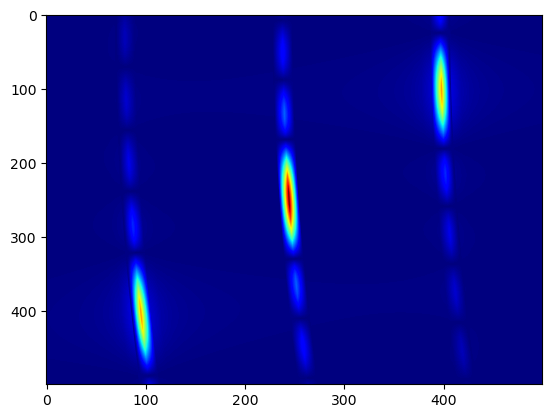

In [7]:
plt.imshow(np.abs(image) / np.max(np.abs(image)), cmap='jet', aspect='auto')

#### Backprojection Backhoe

In [8]:
data = loadmat("./sample_data/backhoe_el000_az350to100.mat")
vv_data = np.squeeze(data['VV'])
hh_data = np.squeeze(data['HH'])
hv_data = np.squeeze(data['HV'])
az_data = np.squeeze(data['AZ'])
el_data = np.squeeze(data['EL'])
freqs   = np.squeeze(data['FGHz']) * 1e+9

In [9]:
freq_step = freqs[1] - freqs[0]
time_step = 1 / (2 * (freqs[1] - freqs[0]))
bandwidth = freq_step * freqs.shape[0]
ranges = np.linspace(-0.5 * c * time_step, 0.5 * c * time_step, 4096)
wavelength = c / freqs[0]

In [10]:
image_length_x = 10
image_length_y = 10
image_bins_x = 1000
image_bins_y = 1000

In [11]:
az_start = 0
az_end = 90
i = 0
index = []
sensor_az = []
for az in az_data:
    if az >= az_start and az <= az_end:
        sensor_az.append(np.radians(az))
        index.append(i)
        i += 1
signal = np.squeeze(vv_data)[:, index] + np.squeeze(hh_data)[:, index] + np.squeeze(hv_data)[:, index]
sensor_el = np.ones_like(sensor_az) * np.radians(30)

In [12]:
diagonal_range  = np.sqrt(image_length_x ** 2 + image_length_y ** 2)
x = np.linspace(-0.5 * image_length_x, 0.5 * image_length_x, image_bins_x)
y = np.linspace(-0.5 * image_length_y, 0.5 * image_length_y, image_bins_y)
[image_grid_x, image_grid_y] = np.meshgrid(x, y)
image_grid_z = np.zeros(image_grid_x.shape)

In [13]:
fft_length = int(4 * 2**(np.ceil(np.log2(freqs.shape[0]))))
range_extent = c / (2 * freq_step)
range_window = np.linspace(-0.5 * range_extent, 0.5 * range_extent, fft_length)
backprojected_image = np.zeros(image_grid_x.shape, dtype=complex)
chirp_rate = 1j * 4 * pi * (1 / wavelength)
num_pulses = az_data.shape[0]
index = 0
for az, el in zip(sensor_az, sensor_el):
    range_profile = fftshift(ifft(signal[:, index], fft_length))
    range_image = image_grid_x * np.cos(el) * np.cos(az) + image_grid_y * np.cos(el) * np.sin(az) + image_grid_z * np.sin(el)
    interpolater = scipy.interpolate.interp1d(range_window, range_profile, kind='linear', bounds_error=False, fill_value=0.0)
    backprojected_image += interpolater(range_image) * np.exp(chirp_rate * range_image)
    if num_pulses != 0 and num_pulses == index:
        break
    index += 1

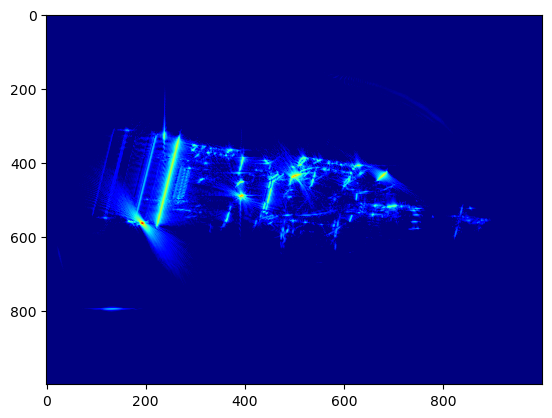

In [14]:
norm = 20 * np.log10(np.abs(backprojected_image) / np.max(np.abs(backprojected_image)))
plt.imshow(norm, cmap='jet', aspect='auto', vmin=-65, vmax=0)

#### Polar Format Backhoe ***
Technically this is more in line with the Polar Format Algorithm. This is a direct, minimal effort, application of the Fourier Slice Theorem.

In [15]:
data = loadmat("./sample_data/backhoe_el030_az350to100.mat")
vv = np.squeeze(data['VV'])
hh = np.squeeze(data['HH'])
hv = np.squeeze(data['HV'])

In [16]:
num_freqs = 500
signal = np.squeeze(vv[0:num_freqs]) + np.squeeze(hh[0:num_freqs]) + np.squeeze(hv[0:num_freqs])

In [17]:
backprojected_image = (fftshift(fftshift(ifft2(signal), 0), 1)).transpose()

In [18]:
norm = 20 * np.log10(np.abs(backprojected_image) / np.max(np.abs(backprojected_image)))

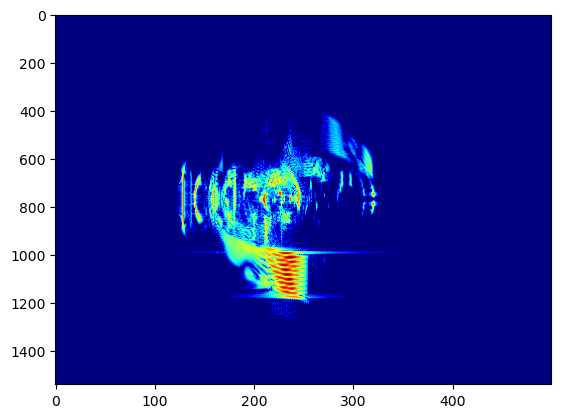

In [19]:
plt.imshow(norm, cmap='jet', aspect='auto', vmin=-35, vmax=0)